In [1]:
import os
import zarr
import timm
import random
import json
import gc
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict
import sys
import torch
from torch.cuda.amp import autocast, GradScaler

# import torchvision.transforms.functional as F
import random

warnings.filterwarnings("ignore")
sys.path.append("./src/")

from src.config import CFG
from src.dataloader import (
    read_zarr,
    read_info_json,
    scale_coordinates,
    create_dataset,
    create_segmentation_map,
    EziiDataset,
    drop_padding,
)
from src.network import Unet3D
from src.utils import save_images, PadToSize
from src.metric import (
    score,
    create_cls_pos,
    create_cls_pos_sikii,
    create_df,
    SegmentationLoss,
    DiceLoss,
)
from src.kaggle_notebook_metric import compute_lb, extract_particle_results
from src.inference import inference, inference2pos, create_gt_df
from metric import visualize_epoch_results

import wandb
from pathlib import Path

notebook_name = os.path.join(Path().resolve()).split("/")[-1]

param = {
    "model": CFG.model_name,
    "resolution": CFG.resolution,
    "augmentation_prob": CFG.augmentation_prob,
    "slice": CFG.slice_,
    "epochs": CFG.epochs,
    "lr": CFG.lr,
    "batch_size": CFG.batch_size,
    "weight_decay": CFG.weight_decay,
    "num_workers": CFG.num_workers,
    "augment_data_ratio": CFG.augment_data_ratio,
}
wandb.init(project="czii2024", name=notebook_name, config=param)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tatuya (latent-walkers). Use `wandb login --relogin` to force relogin


In [2]:
train_dataset = EziiDataset(
    exp_names=CFG.train_exp_names,
    base_dir="../../inputs/train/",
    particles_name=CFG.particles_name,
    resolution=CFG.resolution,
    zarr_type=CFG.train_zarr_types,
    train=True,
    augmentation=True,
    slice=True,
    pre_read=True,
)

# train_nshuffle_dataset = EziiDataset(
#     exp_names=CFG.train_exp_names,
#     base_dir="../../inputs/train/",
#     particles_name=CFG.particles_name,
#     resolution=CFG.resolution,
#     zarr_type=CFG.train_zarr_types,
#     augmentation=False,
#     train=True,
# )

valid_dataset = EziiDataset(
    exp_names=CFG.valid_exp_names,
    base_dir="../../inputs/train/",
    particles_name=CFG.particles_name,
    resolution=CFG.resolution,
    zarr_type=CFG.valid_zarr_types,
    augmentation=False,
    train=True,
    slice=True,
    pre_read=True,
)

from tqdm import tqdm

train_loader = DataLoader(
    train_dataset,
    batch_size=CFG.batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=CFG.num_workers,
)
# train_nshuffle_loader = DataLoader(
#     train_nshuffle_dataset,
#     batch_size=1,
#     shuffle=True,
#     drop_last=True,
#     pin_memory=True,
#     num_workers=CFG.num_workers,
# )
valid_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    pin_memory=True,
    num_workers=CFG.num_workers,
)

for data in tqdm(train_loader):
    normalized_tomogram = data["normalized_tomogram"]
    segmentation_map = data["segmentation_map"]
    break

normalized_tomogram.shape

  0%|          | 0/280 [00:03<?, ?it/s]


torch.Size([2, 16, 630, 630])

In [3]:
# 学習時のデータパターン

z_list = []

for i in range(len(train_dataset)):
    z = train_dataset[i]["zarr_type"]
    z_list.append(z)

np.unique(np.array(z_list), return_counts=True)

(array(['ctfdeconvolved', 'denoised', 'isonetcorrected', 'none', 'wbp'],
       dtype='<U15'),
 array([ 66,  66,  66, 297,  66]))

In [4]:
encoder = timm.create_model(
    model_name=CFG.model_name,
    pretrained=True,
    in_chans=3,
    num_classes=0,
    global_pool="",
    features_only=True,
)
model = Unet3D(encoder=encoder, num_domains=5).to("cuda")
# model.load_state_dict(torch.load("./pretrained_model.pth"))
# model.load_state_dict(
#     torch.load(
#         "../../../../../../../../mnt/d/kaggle-tmp-models/czii2024/exp059-recreate-baseline-renet34d-dstride-attention/model_4.pth"
#     )
# )
# model.load_state_dict(torch.load("./best_model.pth"))

In [5]:
# input-test

x = torch.randn(2, 16, 1, 64, 64).cuda()
model(x, torch.tensor([2, 0]).cuda()).shape

torch.Size([2, 7, 16, 64, 64])

In [6]:
# # "encoder"と名のつくパラメータは学習しない
# for layer, param in model.named_parameters():
#     if "encoder" in layer:
#         param.requires_grad = False

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# サンプルデータ
num_classes = len(CFG.particles_name)  # クラス数
colors = plt.cm.tab10(
    np.arange(len(CFG.particles_name))
)  # "tab10" カラーマップから色を取得

# ListedColormap を作成
class_colormap = ListedColormap(colors)


# カラーバー付きプロット
def plot_with_colormap(data, title, original_tomogram):
    masked_data = np.ma.masked_where(data <= 0, data)  # クラス0をマスク
    plt.imshow(original_tomogram, cmap="gray")
    im = plt.imshow(masked_data, cmap=class_colormap)
    plt.title(title)
    plt.axis("off")
    return im

In [8]:
import torch
import random
import torchvision.transforms.functional as TF


# 回転
# 3Dテンソルの各軸に対して指定した角度で回転する関数
def rotate_3d(tomogram, segmentation_map, angle):
    """Rotates the 3D tensors tomogram and segmentation_map around the Z-axis."""
    rotated_tomogram = TF.rotate(tomogram, angle, expand=False)
    rotated_segmentation_map = TF.rotate(segmentation_map, angle, expand=False)
    return rotated_tomogram, rotated_segmentation_map


# 平行移動
# 指定された範囲でランダムに平行移動
def translate_3d(tomogram, segmentation_map, max_shift):
    """Translates the 3D tensors by a random shift within max_shift."""
    shift_x = random.randint(-max_shift, max_shift)
    shift_y = random.randint(-max_shift, max_shift)
    translated_tomogram = TF.affine(
        tomogram, angle=0, translate=(shift_x, shift_y), scale=1, shear=0
    )
    translated_segmentation_map = TF.affine(
        segmentation_map, angle=0, translate=(shift_x, shift_y), scale=1, shear=0
    )
    return translated_tomogram, translated_segmentation_map


# フリップ
# 縦横（上下左右）ランダムフリップ
def flip_3d(tomogram, segmentation_map):
    """Randomly flips the 3D tensors along height or width."""
    if random.random() > 0.5:  # Horizontal flip
        tomogram = torch.flip(tomogram, dims=[-1])
        segmentation_map = torch.flip(segmentation_map, dims=[-1])
    if random.random() > 0.5:  # Vertical flip
        tomogram = torch.flip(tomogram, dims=[-2])
        segmentation_map = torch.flip(segmentation_map, dims=[-2])
    return tomogram, segmentation_map


# クロッピング
# 入力テンソルを中心またはランダムクロップで切り取る
def crop_3d(tomogram, segmentation_map, crop_size):
    """Crops the 3D tensors to the specified crop_size."""
    _, depth, height, width = tomogram.size()
    crop_d, crop_h, crop_w = crop_size

    if crop_h > height or crop_w > width:
        raise ValueError("Crop size cannot be larger than the original size.")

    start_h = random.randint(0, height - crop_h)  # Random starting position for height
    start_w = random.randint(0, width - crop_w)  # Random starting position for width

    cropped_tomogram = tomogram[
        :, :, start_h : start_h + crop_h, start_w : start_w + crop_w
    ]
    cropped_segmentation_map = segmentation_map[
        :, :, start_h : start_h + crop_h, start_w : start_w + crop_w
    ]

    return cropped_tomogram, cropped_segmentation_map


# Mixup
# 2つのサンプルを線形補間して混合
def mixup(tomogram, segmentation_map, alpha=0.4):
    """Applies mixup augmentation to the batch."""
    lam = random.betavariate(alpha, alpha)
    batch_size = tomogram.size(0)
    index = torch.randperm(batch_size)

    mixed_tomogram = lam * tomogram + (1 - lam) * tomogram[index, :]
    mixed_segmentation_map = (
        lam * segmentation_map + (1 - lam) * segmentation_map[index, :]
    )

    return mixed_tomogram, mixed_segmentation_map


# Cutmix
# ランダム領域を切り取って別のサンプルに貼り付け
def cutmix(tomogram, segmentation_map, alpha=1.0):
    """Applies cutmix augmentation to the batch."""
    lam = random.betavariate(alpha, alpha)
    batch_size, depth, height, width = tomogram.size()
    index = torch.randperm(batch_size)

    cx = random.randint(0, width)
    cy = random.randint(0, height)
    cw = int(width * (1 - lam))
    ch = int(height * (1 - lam))

    x1 = max(cx - cw // 2, 0)
    x2 = min(cx + cw // 2, width)
    y1 = max(cy - ch // 2, 0)
    y2 = min(cy + ch // 2, height)

    tomogram[:, :, y1:y2, x1:x2] = tomogram[index, :, y1:y2, x1:x2]
    segmentation_map[:, :, y1:y2, x1:x2] = segmentation_map[index, :, y1:y2, x1:x2]

    return tomogram, segmentation_map


# データ拡張の組み合わせ適用
def augment_data(
    tomogram,
    segmentation_map,
    crop_size=(16, 256, 256),
    max_shift=10,
    rotation_angle=30,
    p=0.5,
    mixup_alpha=0.4,
    cutmix_alpha=1.0,
):
    """Applies a combination of rotation, translation, flipping, cropping, mixup, and cutmix to the inputs with probabilities."""
    if random.random() < p:
        tomogram, segmentation_map = rotate_3d(
            tomogram,
            segmentation_map,
            angle=random.uniform(-rotation_angle, rotation_angle),
        )
    if random.random() < p:
        tomogram, segmentation_map = translate_3d(
            tomogram, segmentation_map, max_shift=max_shift
        )
    if random.random() < p:
        tomogram, segmentation_map = flip_3d(tomogram, segmentation_map)
    if random.random() < p:
        tomogram, segmentation_map = crop_3d(
            tomogram, segmentation_map, crop_size=crop_size
        )
    if random.random() < p:
        tomogram, segmentation_map = mixup(
            tomogram, segmentation_map, alpha=mixup_alpha
        )
    # if random.random() < p:
    #     tomogram, segmentation_map = cutmix(
    #         tomogram, segmentation_map, alpha=cutmix_alpha
    #     )
    return tomogram, segmentation_map


# 使用例
# バッチサイズ6, 深さ16, 高さ320, 幅320のランダムテンソル
tomogram = torch.rand((6, 16, 320, 320))
segmentation_map = torch.randint(0, 2, (6, 16, 320, 320))  # ラベルは0または1

# データ拡張の適用
aug_tomogram, aug_segmentation_map = augment_data(tomogram, segmentation_map, p=0.7)
print("Original shape:", tomogram.shape)
print("Augmented shape:", aug_tomogram.shape)

Original shape: torch.Size([6, 16, 320, 320])
Augmented shape: torch.Size([6, 16, 320, 320])


In [9]:
# model.encoderのパラメータを固定

# for param in model.encoder.parameters():
#     param.requires_grad = False

In [10]:
from transformers import get_cosine_schedule_with_warmup

optimizer = torch.optim.Adam(
    model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay
)
criterion = nn.CrossEntropyLoss(
    #  weight=torch.tensor([2.0, 32, 32, 32, 32, 32, 32]).to("cuda")
)
# criterion = DiceLoss()
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=10,
    num_training_steps=CFG.epochs * len(train_loader),
    # * batch_size,
)
scaler = GradScaler()
seg_loss = SegmentationLoss(criterion)
padf = PadToSize(CFG.resolution)

In [11]:
# b, c, d, h, w = CFG.batch_size, 1, 96, 320, 320

In [12]:
def preprocess_tensor(tensor):
    batch_size, depth, height, width = tensor.shape
    tensor = tensor.unsqueeze(2)  # (b, d, h, w) -> (b, d, 1, h, w)
    return tensor

In [13]:
padf = PadToSize(CFG.resolution)
padf(normalized_tomogram).shape

torch.Size([2, 16, 640, 640])

In [14]:
best_model = None
best_constant = 0
best_score = -100
best_particle_score = {}

grand_train_loss = []
grand_valid_loss = []
grand_train_score = []
grand_valid_score = []

for epoch in range(CFG.epochs):
    model.train()
    train_loss = []
    valid_loss = []
    with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{CFG.epochs} [Training]") as tq:
        for data in tq:
            normalized_tomogram = data["normalized_tomogram"]
            segmentation_map = data["segmentation_map"]
            zarr_embedding_idx = data["zarr_type_embedding_idx"]

            normalized_tomogram = padf(normalized_tomogram)
            segmentation_map = padf(segmentation_map)

            # データ拡張
            normalized_tomogram, segmentation_map = augment_data(
                normalized_tomogram, segmentation_map, p=CFG.augmentation_prob
            )
            normalized_tomogram = normalized_tomogram.cuda()
            segmentation_map = segmentation_map.long().cuda()
            zarr_embedding_idx = zarr_embedding_idx.cuda()

            optimizer.zero_grad()

            with autocast():
                pred = model(preprocess_tensor(normalized_tomogram), zarr_embedding_idx)
                loss = seg_loss(pred, segmentation_map)
            # loss.backward()
            # optimizer.step()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            train_loss.append(loss.item())

            # 確率予測
            prob_pred = torch.softmax(pred, dim=1)
            tq.set_postfix({"loss": f"{np.mean(train_loss):.4f}"})

    del normalized_tomogram, segmentation_map, zarr_embedding_idx, pred, loss
    gc.collect()
    torch.cuda.empty_cache()

    with tqdm(valid_loader, desc=f"Epoch {epoch + 1}/{CFG.epochs} [Validation]") as tq:
        with torch.no_grad():
            for data in tq:
                normalized_tomogram = data["normalized_tomogram"].cuda()
                segmentation_map = data["segmentation_map"].long().cuda()
                zarr_embedding_idx = data["zarr_type_embedding_idx"].cuda()

                normalized_tomogram = padf(normalized_tomogram)
                segmentation_map = padf(segmentation_map)

                with autocast():
                    pred = model(
                        preprocess_tensor(normalized_tomogram), zarr_embedding_idx
                    )
                    loss = seg_loss(pred, segmentation_map)
                valid_loss.append(loss.item())

                # 確率予測
                prob_pred = torch.softmax(pred, dim=1)
                tq.set_postfix({"loss": f"{np.mean(valid_loss):.4f}"})

    del normalized_tomogram, segmentation_map, zarr_embedding_idx, pred, loss
    gc.collect()
    torch.cuda.empty_cache()

    # # ############### validation ################
    train_nshuffle_original_tomogram = defaultdict(list)
    train_nshuffle_pred_tomogram = defaultdict(list)
    train_nshuffle_gt_tomogram = defaultdict(list)

    valid_original_tomogram = defaultdict(list)
    valid_pred_tomogram = defaultdict(list)
    valid_gt_tomogram = defaultdict(list)

    train_mean_scores = []
    valid_mean_scores = []

    # モデルの保存
    make_dir_ = (
        f"../../../../../../../../mnt/d/kaggle-tmp-models/czii2024/{notebook_name}/"
    )
    os.makedirs(make_dir_, exist_ok=True)
    torch.save(model.state_dict(), make_dir_ + f"model_{epoch}.pth")

    # ############### validation ################
    train_nshuffle_original_tomogram = defaultdict(list)
    train_nshuffle_pred_tomogram = defaultdict(list)
    train_nshuffle_gt_tomogram = defaultdict(list)

    valid_original_tomogram = defaultdict(list)
    valid_pred_tomogram = defaultdict(list)
    valid_gt_tomogram = defaultdict(list)

    train_mean_scores = []
    valid_mean_scores = []

    train_inferenced_array = {}
    train_pred_array = []
    train_gt_array = []
    valid_inferenced_array = {}
    valid_gt_array = []

    # for exp_name in tqdm(CFG.train_exp_names):
    for exp_name in [CFG.valid_exp_name]:  # 5つのデータで試す
        # inferenced_array = inference(model, exp_name, train=False)
        inferenced_array, n_tomogram, segmentation_map = inference(
            model, exp_name, train=False
        )
        valid_inferenced_array[exp_name] = inferenced_array
        base_dir = "../../inputs/train/overlay/ExperimentRuns/"
        gt_df = create_gt_df(base_dir, [exp_name])
        valid_gt_array.append(gt_df)

    valid_gt_array = pd.concat(valid_gt_array)

    b_constant = 0
    b_score = -100
    b_particle_score = {}
    for constant in tqdm(np.linspace(0.05, 0.9, 15)):
        valid_pred_array = []
        sikii = {
            "apo-ferritin": constant,
            "beta-amylase": constant,
            "beta-galactosidase": constant,
            "ribosome": constant,
            "thyroglobulin": constant,
            "virus-like-particle": constant,
        }
        for exp_name in [CFG.valid_exp_name]:  # 5つのデータで試す
            pred_df = inference2pos(
                pred_segmask=valid_inferenced_array[exp_name],
                exp_name=exp_name,
                sikii_dict=sikii,
            )
            valid_pred_array.append(pred_df)

        valid_pred_array = pd.concat(valid_pred_array)

        if len(valid_pred_array) != 0:
            # score_ = score(
            #     valid_pred_array,
            #     valid_gt_array,
            #     row_id_column_name="index",
            #     distance_multiplier=0.5,
            #     beta=4,
            # )
            result_df, score_ = compute_lb(
                valid_pred_array,
                "../../inputs/train/overlay/ExperimentRuns/",
                CFG.valid_exp_names,
            )
            particle_score = extract_particle_results(result_df)

            if score_ > b_score:
                b_score = score_
                b_constant = constant
                b_particle_score = particle_score

        import gc
        import torch.cuda as cuda

        # del valid_pred_array, valid_gt_array
        gc.collect()
        cuda.empty_cache()

    # print("constant", b_constant, "score", b_score)

    # wandb-log
    train_info = {
        "01_epoch": epoch,
        "02_train_loss": np.mean(train_loss),
        "03_valid_loss": np.mean(valid_loss),
        # "train_score": np.mean(train_mean_scores),
        "04_valid_best_score": b_score,
        "05_valid_best_constant": b_constant,
    }
    train_info = {**train_info, **b_particle_score}
    wandb.log(train_info)

    # score-update
    if b_score > best_score:
        best_constant = b_constant
        best_score = b_score
        # best_score = np.mean(valid_mean_scores)
        best_model = model.state_dict()
        torch.save(best_model, f"./best_model.pth")

    print(
        f"train-epoch-loss:{np.mean(train_loss):.4f}",
        # f"valid-epoch-loss:{np.mean(valid_loss):.4f}",
        # f"train-beta4-score:{np.mean(train_mean_scores):.4f}",
        f"valid-beta4-score:{b_score:.4f}",
    )

    grand_train_loss.append(np.mean(train_loss))
    # grand_valid_loss.append(np.mean(valid_loss))
    # grand_train_score.append(np.mean(train_mean_scores))
    grand_valid_score.append(b_score)

100%|██████████| 15/15 [00:34<00:00,  2.32s/it]


train-epoch-loss:1.0465 valid-beta4-score:0.0420


100%|██████████| 15/15 [00:35<00:00,  2.39s/it]


train-epoch-loss:0.2651 valid-beta4-score:0.1546


100%|██████████| 15/15 [00:31<00:00,  2.12s/it]


train-epoch-loss:0.1039 valid-beta4-score:0.1797


100%|██████████| 15/15 [00:33<00:00,  2.26s/it]


train-epoch-loss:0.0648 valid-beta4-score:0.1227


100%|██████████| 15/15 [00:34<00:00,  2.29s/it]


train-epoch-loss:0.0486 valid-beta4-score:0.3874


100%|██████████| 15/15 [00:32<00:00,  2.20s/it]


train-epoch-loss:0.0415 valid-beta4-score:0.4765


100%|██████████| 15/15 [00:34<00:00,  2.27s/it]


train-epoch-loss:0.0367 valid-beta4-score:0.4508


100%|██████████| 15/15 [00:35<00:00,  2.36s/it]


train-epoch-loss:0.0322 valid-beta4-score:0.4782


100%|██████████| 15/15 [00:35<00:00,  2.35s/it]


train-epoch-loss:0.0311 valid-beta4-score:0.4440


100%|██████████| 15/15 [00:33<00:00,  2.25s/it]


train-epoch-loss:0.0316 valid-beta4-score:0.4375


100%|██████████| 15/15 [00:35<00:00,  2.35s/it]


train-epoch-loss:0.0283 valid-beta4-score:0.4307


100%|██████████| 15/15 [00:35<00:00,  2.36s/it]


train-epoch-loss:0.0242 valid-beta4-score:0.5375


100%|██████████| 15/15 [00:34<00:00,  2.29s/it]


train-epoch-loss:0.0247 valid-beta4-score:0.5407


100%|██████████| 15/15 [00:34<00:00,  2.28s/it]


train-epoch-loss:0.0232 valid-beta4-score:0.4807


100%|██████████| 15/15 [00:34<00:00,  2.29s/it]


train-epoch-loss:0.0238 valid-beta4-score:0.5310


100%|██████████| 15/15 [00:34<00:00,  2.28s/it]


train-epoch-loss:0.0216 valid-beta4-score:0.5285


100%|██████████| 15/15 [00:34<00:00,  2.30s/it]


train-epoch-loss:0.0211 valid-beta4-score:0.6069


100%|██████████| 15/15 [00:33<00:00,  2.22s/it]


train-epoch-loss:0.0191 valid-beta4-score:0.5137


100%|██████████| 15/15 [00:34<00:00,  2.27s/it]


train-epoch-loss:0.0234 valid-beta4-score:0.5361


100%|██████████| 15/15 [00:35<00:00,  2.34s/it]


train-epoch-loss:0.0195 valid-beta4-score:0.5640


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


train-epoch-loss:0.0194 valid-beta4-score:0.5499


100%|██████████| 15/15 [00:34<00:00,  2.33s/it]


train-epoch-loss:0.0180 valid-beta4-score:0.4966


100%|██████████| 15/15 [00:35<00:00,  2.37s/it]


train-epoch-loss:0.0198 valid-beta4-score:0.5330


100%|██████████| 15/15 [00:35<00:00,  2.38s/it]


train-epoch-loss:0.0195 valid-beta4-score:0.5099


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


train-epoch-loss:0.0183 valid-beta4-score:0.5479


100%|██████████| 15/15 [00:34<00:00,  2.32s/it]


train-epoch-loss:0.0169 valid-beta4-score:0.4752


100%|██████████| 15/15 [00:35<00:00,  2.40s/it]


train-epoch-loss:0.0192 valid-beta4-score:0.5717


100%|██████████| 15/15 [00:35<00:00,  2.33s/it]


train-epoch-loss:0.0178 valid-beta4-score:0.5235


100%|██████████| 15/15 [00:35<00:00,  2.35s/it]


train-epoch-loss:0.0167 valid-beta4-score:0.5786


100%|██████████| 15/15 [00:35<00:00,  2.37s/it]


train-epoch-loss:0.0192 valid-beta4-score:0.6647


100%|██████████| 15/15 [00:35<00:00,  2.34s/it]


train-epoch-loss:0.0182 valid-beta4-score:0.5716


100%|██████████| 15/15 [00:35<00:00,  2.34s/it]


train-epoch-loss:0.0177 valid-beta4-score:0.5950


100%|██████████| 15/15 [00:35<00:00,  2.36s/it]


train-epoch-loss:0.0173 valid-beta4-score:0.5585


100%|██████████| 15/15 [00:34<00:00,  2.30s/it]


train-epoch-loss:0.0180 valid-beta4-score:0.5809


100%|██████████| 15/15 [00:35<00:00,  2.35s/it]


train-epoch-loss:0.0176 valid-beta4-score:0.6181


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


train-epoch-loss:0.0166 valid-beta4-score:0.6139


100%|██████████| 15/15 [00:34<00:00,  2.33s/it]


train-epoch-loss:0.0173 valid-beta4-score:0.5117


100%|██████████| 15/15 [00:35<00:00,  2.34s/it]


train-epoch-loss:0.0177 valid-beta4-score:0.6421


100%|██████████| 15/15 [00:35<00:00,  2.36s/it]


train-epoch-loss:0.0167 valid-beta4-score:0.6012


100%|██████████| 15/15 [00:35<00:00,  2.39s/it]


train-epoch-loss:0.0150 valid-beta4-score:0.6165


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


train-epoch-loss:0.0164 valid-beta4-score:0.5999


100%|██████████| 15/15 [00:35<00:00,  2.37s/it]


train-epoch-loss:0.0166 valid-beta4-score:0.5845


100%|██████████| 15/15 [00:35<00:00,  2.40s/it]


train-epoch-loss:0.0169 valid-beta4-score:0.5988


100%|██████████| 15/15 [00:35<00:00,  2.35s/it]


train-epoch-loss:0.0159 valid-beta4-score:0.6525


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


train-epoch-loss:0.0134 valid-beta4-score:0.6395


100%|██████████| 15/15 [00:35<00:00,  2.35s/it]


train-epoch-loss:0.0165 valid-beta4-score:0.5947


100%|██████████| 15/15 [00:35<00:00,  2.39s/it]


train-epoch-loss:0.0150 valid-beta4-score:0.5407


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


train-epoch-loss:0.0148 valid-beta4-score:0.6352


100%|██████████| 15/15 [00:35<00:00,  2.36s/it]


train-epoch-loss:0.0151 valid-beta4-score:0.5700


100%|██████████| 15/15 [00:35<00:00,  2.37s/it]


train-epoch-loss:0.0148 valid-beta4-score:0.6081


100%|██████████| 15/15 [00:35<00:00,  2.35s/it]


train-epoch-loss:0.0153 valid-beta4-score:0.4752


100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


train-epoch-loss:0.0164 valid-beta4-score:0.5835


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


train-epoch-loss:0.0138 valid-beta4-score:0.6312


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


train-epoch-loss:0.0148 valid-beta4-score:0.5869


100%|██████████| 15/15 [00:35<00:00,  2.34s/it]


train-epoch-loss:0.0135 valid-beta4-score:0.5975


100%|██████████| 15/15 [00:35<00:00,  2.35s/it]


train-epoch-loss:0.0126 valid-beta4-score:0.6111


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


train-epoch-loss:0.0142 valid-beta4-score:0.5593


100%|██████████| 15/15 [00:35<00:00,  2.39s/it]


train-epoch-loss:0.0125 valid-beta4-score:0.5986


100%|██████████| 15/15 [00:35<00:00,  2.36s/it]


train-epoch-loss:0.0163 valid-beta4-score:0.6299


100%|██████████| 15/15 [00:34<00:00,  2.30s/it]


train-epoch-loss:0.0131 valid-beta4-score:0.5865


100%|██████████| 15/15 [00:35<00:00,  2.38s/it]


train-epoch-loss:0.0128 valid-beta4-score:0.6014


100%|██████████| 15/15 [00:35<00:00,  2.37s/it]


train-epoch-loss:0.0128 valid-beta4-score:0.6363


100%|██████████| 15/15 [00:35<00:00,  2.36s/it]


train-epoch-loss:0.0152 valid-beta4-score:0.5501


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


train-epoch-loss:0.0130 valid-beta4-score:0.6096


100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


train-epoch-loss:0.0122 valid-beta4-score:0.6489


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


train-epoch-loss:0.0139 valid-beta4-score:0.7124


100%|██████████| 15/15 [00:35<00:00,  2.37s/it]


train-epoch-loss:0.0142 valid-beta4-score:0.6426


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


train-epoch-loss:0.0113 valid-beta4-score:0.5855


100%|██████████| 15/15 [00:36<00:00,  2.45s/it]


train-epoch-loss:0.0122 valid-beta4-score:0.7211


100%|██████████| 15/15 [00:35<00:00,  2.38s/it]


train-epoch-loss:0.0113 valid-beta4-score:0.5710


100%|██████████| 15/15 [00:35<00:00,  2.37s/it]


train-epoch-loss:0.0123 valid-beta4-score:0.5710


100%|██████████| 15/15 [00:36<00:00,  2.44s/it]


train-epoch-loss:0.0114 valid-beta4-score:0.6410


100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


train-epoch-loss:0.0123 valid-beta4-score:0.5838


100%|██████████| 15/15 [00:35<00:00,  2.39s/it]


train-epoch-loss:0.0115 valid-beta4-score:0.6589


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


train-epoch-loss:0.0111 valid-beta4-score:0.6672


100%|██████████| 15/15 [00:35<00:00,  2.36s/it]


train-epoch-loss:0.0124 valid-beta4-score:0.5875


100%|██████████| 15/15 [00:34<00:00,  2.28s/it]


train-epoch-loss:0.0126 valid-beta4-score:0.6425


100%|██████████| 15/15 [00:34<00:00,  2.32s/it]


train-epoch-loss:0.0107 valid-beta4-score:0.7058


100%|██████████| 15/15 [00:36<00:00,  2.46s/it]


train-epoch-loss:0.0113 valid-beta4-score:0.6258


100%|██████████| 15/15 [00:35<00:00,  2.34s/it]


train-epoch-loss:0.0117 valid-beta4-score:0.6759


100%|██████████| 15/15 [00:33<00:00,  2.26s/it]


train-epoch-loss:0.0115 valid-beta4-score:0.5649


100%|██████████| 15/15 [00:33<00:00,  2.22s/it]


train-epoch-loss:0.0135 valid-beta4-score:0.6134


100%|██████████| 15/15 [00:35<00:00,  2.35s/it]


train-epoch-loss:0.0123 valid-beta4-score:0.5527


100%|██████████| 15/15 [00:34<00:00,  2.30s/it]


train-epoch-loss:0.0109 valid-beta4-score:0.6194


100%|██████████| 15/15 [00:35<00:00,  2.36s/it]


train-epoch-loss:0.0109 valid-beta4-score:0.6753


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


train-epoch-loss:0.0110 valid-beta4-score:0.6322


100%|██████████| 15/15 [00:35<00:00,  2.38s/it]


train-epoch-loss:0.0116 valid-beta4-score:0.6433


100%|██████████| 15/15 [00:36<00:00,  2.45s/it]


train-epoch-loss:0.0109 valid-beta4-score:0.5151


100%|██████████| 15/15 [00:36<00:00,  2.45s/it]


train-epoch-loss:0.0099 valid-beta4-score:0.5716


100%|██████████| 15/15 [00:35<00:00,  2.40s/it]


train-epoch-loss:0.0123 valid-beta4-score:0.5571


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


train-epoch-loss:0.0111 valid-beta4-score:0.5994


100%|██████████| 15/15 [00:37<00:00,  2.50s/it]


train-epoch-loss:0.0123 valid-beta4-score:0.6092


100%|██████████| 15/15 [00:35<00:00,  2.39s/it]


train-epoch-loss:0.0120 valid-beta4-score:0.6437


100%|██████████| 15/15 [00:34<00:00,  2.32s/it]


train-epoch-loss:0.0114 valid-beta4-score:0.5339


100%|██████████| 15/15 [00:37<00:00,  2.53s/it]


train-epoch-loss:0.0114 valid-beta4-score:0.5787


100%|██████████| 15/15 [00:35<00:00,  2.40s/it]


train-epoch-loss:0.0104 valid-beta4-score:0.5706


100%|██████████| 15/15 [00:37<00:00,  2.50s/it]


train-epoch-loss:0.0106 valid-beta4-score:0.6484


100%|██████████| 15/15 [00:38<00:00,  2.54s/it]


train-epoch-loss:0.0090 valid-beta4-score:0.6121


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


train-epoch-loss:0.0112 valid-beta4-score:0.6286


100%|██████████| 15/15 [00:37<00:00,  2.52s/it]


train-epoch-loss:0.0110 valid-beta4-score:0.6496


100%|██████████| 15/15 [00:38<00:00,  2.55s/it]


train-epoch-loss:0.0093 valid-beta4-score:0.6492


100%|██████████| 15/15 [00:36<00:00,  2.44s/it]


train-epoch-loss:0.0102 valid-beta4-score:0.6209


100%|██████████| 15/15 [00:38<00:00,  2.54s/it]


train-epoch-loss:0.0107 valid-beta4-score:0.6080


100%|██████████| 15/15 [00:38<00:00,  2.53s/it]


train-epoch-loss:0.0114 valid-beta4-score:0.6493


100%|██████████| 15/15 [00:36<00:00,  2.44s/it]


train-epoch-loss:0.0091 valid-beta4-score:0.5971


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


train-epoch-loss:0.0098 valid-beta4-score:0.5635


100%|██████████| 15/15 [00:36<00:00,  2.47s/it]


train-epoch-loss:0.0103 valid-beta4-score:0.5971


100%|██████████| 15/15 [00:36<00:00,  2.46s/it]


train-epoch-loss:0.0106 valid-beta4-score:0.6555


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


train-epoch-loss:0.0112 valid-beta4-score:0.6205


100%|██████████| 15/15 [00:36<00:00,  2.45s/it]


train-epoch-loss:0.0100 valid-beta4-score:0.5884


100%|██████████| 15/15 [00:37<00:00,  2.50s/it]


train-epoch-loss:0.0103 valid-beta4-score:0.5770


100%|██████████| 15/15 [00:35<00:00,  2.37s/it]


train-epoch-loss:0.0098 valid-beta4-score:0.5723


100%|██████████| 15/15 [00:36<00:00,  2.44s/it]


train-epoch-loss:0.0115 valid-beta4-score:0.5664


100%|██████████| 15/15 [00:35<00:00,  2.40s/it]


train-epoch-loss:0.0107 valid-beta4-score:0.5716


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


train-epoch-loss:0.0101 valid-beta4-score:0.6446


100%|██████████| 15/15 [00:36<00:00,  2.45s/it]


train-epoch-loss:0.0102 valid-beta4-score:0.5610


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


train-epoch-loss:0.0106 valid-beta4-score:0.5482


100%|██████████| 15/15 [00:36<00:00,  2.44s/it]


train-epoch-loss:0.0106 valid-beta4-score:0.6046


100%|██████████| 15/15 [00:35<00:00,  2.39s/it]


train-epoch-loss:0.0105 valid-beta4-score:0.5489


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


train-epoch-loss:0.0105 valid-beta4-score:0.5879


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


train-epoch-loss:0.0101 valid-beta4-score:0.5796


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


train-epoch-loss:0.0107 valid-beta4-score:0.5667


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


train-epoch-loss:0.0120 valid-beta4-score:0.5854


100%|██████████| 15/15 [00:35<00:00,  2.40s/it]


train-epoch-loss:0.0096 valid-beta4-score:0.6269


100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


train-epoch-loss:0.0101 valid-beta4-score:0.5782


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


train-epoch-loss:0.0112 valid-beta4-score:0.5709


100%|██████████| 15/15 [00:36<00:00,  2.45s/it]


train-epoch-loss:0.0104 valid-beta4-score:0.5405


100%|██████████| 15/15 [00:36<00:00,  2.44s/it]


train-epoch-loss:0.0103 valid-beta4-score:0.5987


100%|██████████| 15/15 [00:34<00:00,  2.33s/it]


train-epoch-loss:0.0091 valid-beta4-score:0.5747


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


train-epoch-loss:0.0090 valid-beta4-score:0.6384


100%|██████████| 15/15 [00:36<00:00,  2.44s/it]


train-epoch-loss:0.0086 valid-beta4-score:0.5915


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


train-epoch-loss:0.0088 valid-beta4-score:0.6186


100%|██████████| 15/15 [00:36<00:00,  2.45s/it]


train-epoch-loss:0.0089 valid-beta4-score:0.5779


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


train-epoch-loss:0.0089 valid-beta4-score:0.5770


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


train-epoch-loss:0.0087 valid-beta4-score:0.6212


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


train-epoch-loss:0.0091 valid-beta4-score:0.5850


100%|██████████| 15/15 [00:36<00:00,  2.45s/it]


train-epoch-loss:0.0090 valid-beta4-score:0.5667


100%|██████████| 15/15 [00:37<00:00,  2.51s/it]


train-epoch-loss:0.0091 valid-beta4-score:0.5986


100%|██████████| 15/15 [00:36<00:00,  2.46s/it]


train-epoch-loss:0.0082 valid-beta4-score:0.5759


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


train-epoch-loss:0.0097 valid-beta4-score:0.5501


100%|██████████| 15/15 [00:36<00:00,  2.46s/it]


train-epoch-loss:0.0096 valid-beta4-score:0.5354


100%|██████████| 15/15 [00:36<00:00,  2.44s/it]


train-epoch-loss:0.0096 valid-beta4-score:0.5899


100%|██████████| 15/15 [00:36<00:00,  2.44s/it]


train-epoch-loss:0.0113 valid-beta4-score:0.5773


100%|██████████| 15/15 [00:36<00:00,  2.45s/it]


train-epoch-loss:0.0092 valid-beta4-score:0.5897


100%|██████████| 15/15 [00:36<00:00,  2.46s/it]


train-epoch-loss:0.0096 valid-beta4-score:0.5724


100%|██████████| 15/15 [00:36<00:00,  2.46s/it]


train-epoch-loss:0.0083 valid-beta4-score:0.6057


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


train-epoch-loss:0.0094 valid-beta4-score:0.5382


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


train-epoch-loss:0.0105 valid-beta4-score:0.6031


100%|██████████| 15/15 [00:37<00:00,  2.50s/it]


train-epoch-loss:0.0097 valid-beta4-score:0.6407


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]

train-epoch-loss:0.0088 valid-beta4-score:0.5731


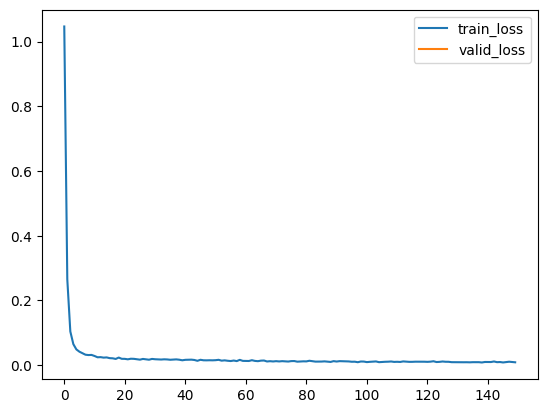

In [15]:
# train_lossとvalid_lossのプロット

plt.plot(grand_train_loss, label="train_loss")
plt.plot(grand_valid_loss, label="valid_loss")
plt.legend()
plt.show()

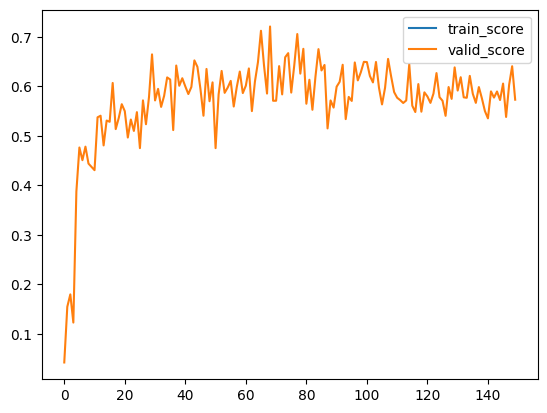

In [16]:
# train_scoreとvalid_scoreのプロット
plt.plot(grand_train_score, label="train_score")
plt.plot(grand_valid_score, label="valid_score")
plt.legend()
plt.show()

In [17]:
random.random()

0.9069232983548293